# Study of warranty costs

In [152]:
# Load packages
import json
import matplotlib.pyplot as plt
import numpy as np
import openturns as ot
import pandas as pd
import scipy
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from bokeh.io import output_notebook, push_notebook, show
from bokeh.plotting import figure
from bokeh.transform import linear_cmap

#from ggplot import *
from sklearn import cluster, mixture
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from fda import *

output_notebook()

Loading BokehJS ...

In [94]:
# Various paramaters
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 15, 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['font.size'] = 15
plt.rcParams['lines.markersize'] = 4
plt.rcParams['axes.linewidth'] = 0.2
plt.rcParams['xtick.major.width'] = 0.2
plt.rcParams['ytick.major.width'] = 0.2

plt.rcParams['text.usetex'] = False
plt.rcParams['font.serif'] = "cm"

In [95]:
# Some functions
def plot_month(data, date):
    """Plot the data for one month."""
    df = data.loc[date]

    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(df)
    ax.set_xlim([0, len(df)-1])
    
    plt.title(' '.join(['Manufacturing month:', date]))
    plt.xlabel('Month since manufacturing')
    plt.ylabel('Cost by vehicle')
    plt.xticks(np.arange(0, len(df), 2))
    plt.grid()
    plt.show()

def plot_months(data):
    """Plot the data for all the months."""
    df = data.T
     
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(df)
    ax.set_xlim([0, len(df)-1])
    
    plt.title('Warranty cost')
    plt.xlabel('Month since manufacturing')
    plt.xticks(np.arange(0, len(df), 2))
    plt.ylabel('Cost per vehicle')
    plt.grid()
    plt.show()
    
def plot_coefs(data, number):
    """Plot the coefficient of a principal component through time."""
    df = data[number]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(month, df)
    
    plt.title(' '.join(['Plot of the scores of the', str(number), 'principal components']))
    plt.xlabel('Months')
    plt.xticks(rotation=45)
    plt.ylabel('Principal components scores')
    plt.grid()
    plt.show()

## Load the data

The data consists of the warranty costs during 24 months for the manufacturing months from January 2013 to December 2015.
The rows represent the different manufacturing months and the columns are the number of months considered after the manufacturing month. So, we have the warranty costs per month.

In [96]:
%%bash
# List the .csv files that are possible to analyze.
ls *.csv

B98.csv
JFC.csv
X82.csv
XFE.csv


In [97]:
# Load the data
df = pd.read_csv('./B98.csv', header=None, index_col=0)

In [98]:
# Let's take a look at the data.
df

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
0,,,,,,,,,,,,,,,,,,,,,
01/2013,2.095211,4.278267,3.961642,2.382186,3.412345,3.130373,3.762847,3.848019,4.544106,7.643071,...,4.877514,4.392725,3.464998,4.650119,5.073246,7.046810,9.076671,11.989240,16.053625,17.473212
02/2013,1.243013,4.677519,4.229476,5.089797,7.779773,7.063859,5.008871,5.345327,7.170142,10.149797,...,5.968644,5.147472,6.465291,7.979396,10.037398,12.955837,12.957628,15.308245,15.915508,17.314180
03/2013,1.320071,4.420377,5.164529,11.326923,12.240197,7.849134,6.264260,7.613348,8.940658,9.188314,...,6.976773,7.497644,6.901841,9.600055,11.511351,15.226597,14.257616,15.700610,13.876145,13.297487
04/2013,1.678648,19.873565,11.560579,10.649665,10.441620,6.067070,6.744401,5.166904,5.535006,6.233233,...,3.821708,6.029104,6.565934,5.054691,5.387032,7.684662,6.330084,8.581286,7.962417,8.903116
05/2013,0.991342,4.414898,3.147982,3.770556,2.010535,3.932643,3.232230,3.629052,3.830632,4.640984,...,4.679165,5.257205,5.930638,6.427134,5.998483,6.522112,6.361454,5.826462,5.748289,6.697727
06/2013,1.689523,4.614420,3.313112,2.980872,2.758816,3.706487,3.544920,3.656641,2.998073,3.807419,...,5.064498,4.087311,4.214941,3.737378,4.765316,5.240615,4.371295,4.959782,5.362924,6.899755
07/2013,1.093334,3.778543,2.442783,2.952084,3.377586,3.558146,4.409285,3.256571,3.808855,2.832352,...,5.054806,5.036016,5.590157,4.105784,5.213898,4.495654,3.507648,4.385827,4.798165,6.692762
08/2013,1.138278,3.329614,5.750160,2.233148,4.019696,3.234900,2.485872,3.738833,2.699228,3.470520,...,2.833161,2.476357,6.143669,3.845035,3.661830,2.706340,3.607741,3.856670,4.657333,7.264553
09/2013,1.274717,3.490802,2.797414,2.619666,3.107207,3.741869,2.886524,3.280172,4.066995,3.264438,...,4.614181,5.566430,4.125779,4.726795,3.213218,4.621961,4.467691,4.005874,4.550033,8.443047


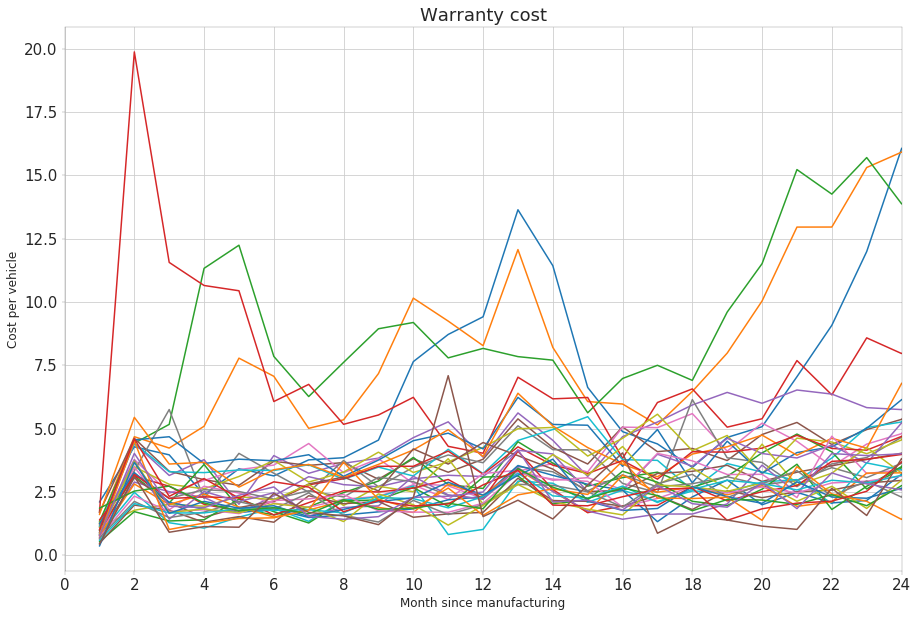

In [99]:
# Plot all the months
plot_months(df)

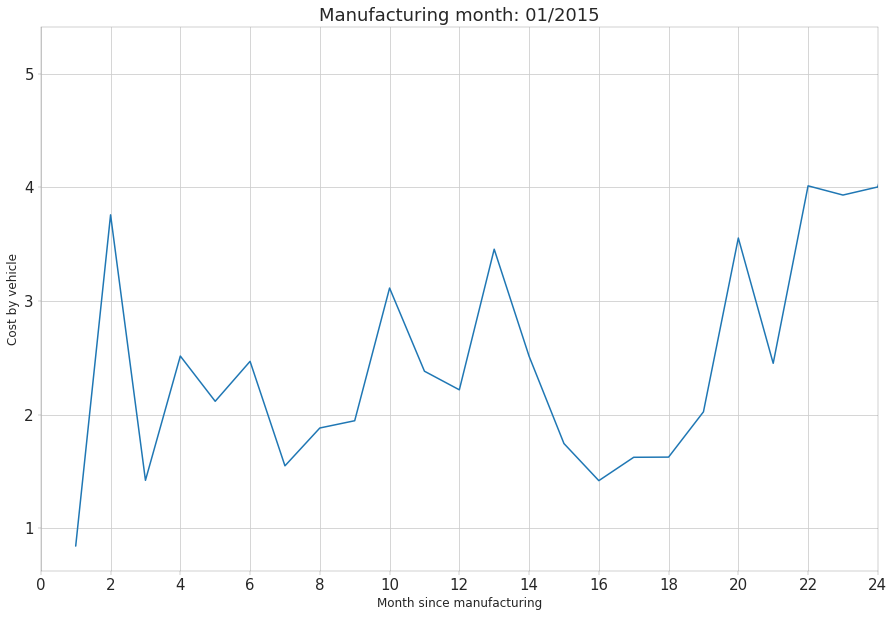

In [100]:
# Plot one month: January 2015
plot_month(df, date='01/2015')

One may also be interested by the cumulative sum of warranty costs until 24 months after the manufacturing.

In [123]:
# Build the cumulative dataframe.
df_cum = df.cumsum(axis=1)

<IPython.core.display.Javascript object>


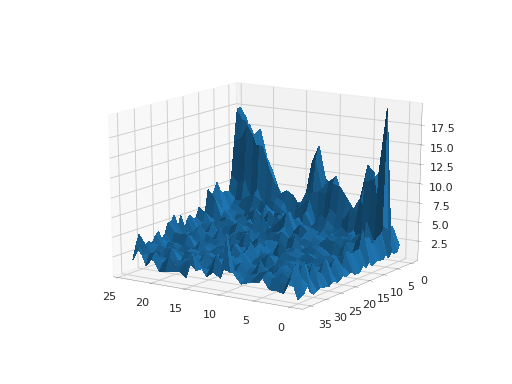

In [298]:
# let's take a look at the cumulative dataframe.
df_cum

Y = range(df_cum.shape[0])
X = range(df_cum.shape[1])
X, Y = np.meshgrid(X, Y)

Z = df.values

%matplotlib notebook
     
        
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z,
                       linewidth=0, antialiased=False)



plt.show()

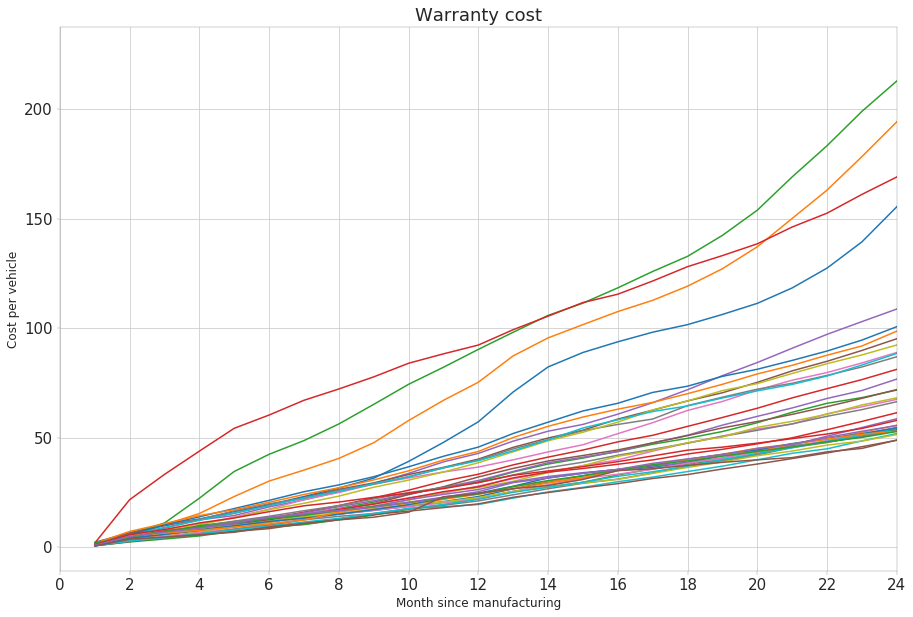

In [103]:
# Plot all the months (cumulative costs)
plot_months(df_cum)

fig = plt.figure()
ax = fig.gca(projection='3d')
theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
z = np.linspace(-2, 2, 100)
r = z**2 + 1
x = r * np.sin(theta)
y = r * np.cos(theta)
ax.plot(x, y, z, label='parametric curve')
ax.legend()

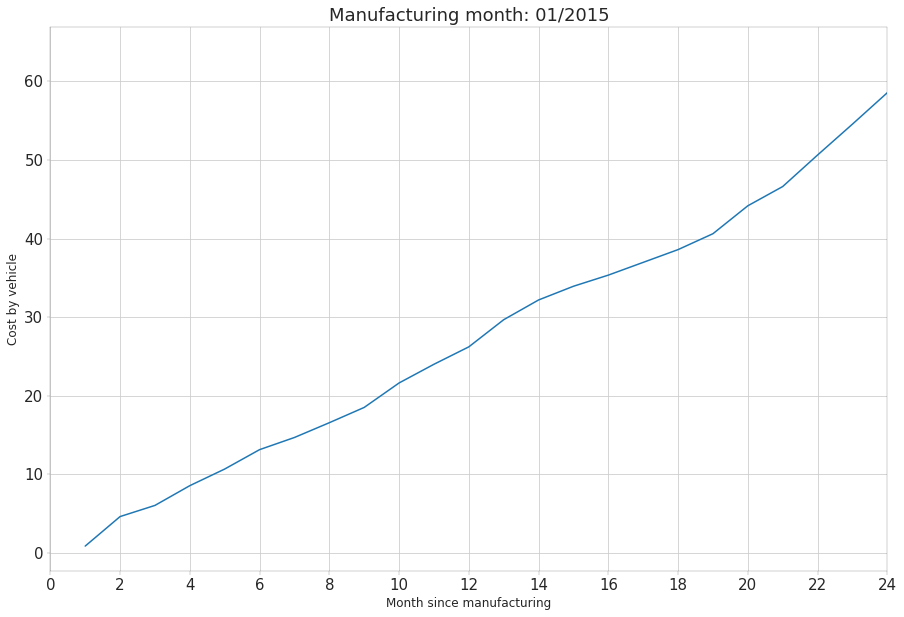

In [104]:
# Plot one month: January 2015
plot_month(df_cum, date='01/2015')

In [105]:
# Retrieve with manufacturing months we consider
month = df.index

In [106]:
month

Index(['01/2013', '02/2013', '03/2013', '04/2013', '05/2013', '06/2013',
       '07/2013', '08/2013', '09/2013', '10/2013', '11/2013', '12/2013',
       '01/2014', '02/2014', '03/2014', '04/2014', '05/2014', '06/2014',
       '07/2014', '08/2014', '09/2014', '10/2014', '11/2014', '12/2014',
       '01/2015', '02/2015', '03/2015', '04/2015', '05/2015', '06/2015',
       '07/2015', '08/2015', '09/2015', '10/2015', '11/2015', '12/2015'],
      dtype='object', name=0)

## Smooth the data

In [107]:
# Smooth the data (maybe don't)
data = {}
for index, row in df.iterrows():
    data[index] = gaussian_kernel_smoothing(X=np.linspace(0, 24, num=25), y=row, grid=np.linspace(0, 24, num=100))
    
# Reorganize the smoothed data
df_smooth = pd.DataFrame.from_dict({i: data[i][0]
                       for i in data.keys()
                       for j in data[i][0]}, orient='index')

In [108]:
# Compute statistics on the reconstruction error
error = []
for val in data.values():
    error.append(val[1])
print('The R² score on the curves is {:.2f} ± {:.2f}.'.format(np.mean(error), np.std(error)))

The R² score on the curves is 0.56 ± 0.23.


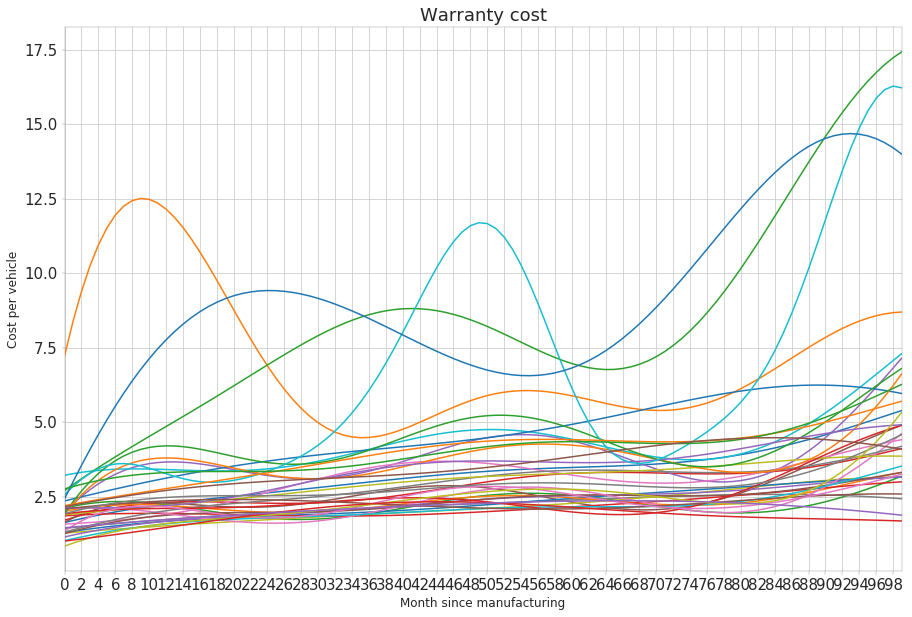

In [109]:
# Plot all the months
plot_months(df_smooth)

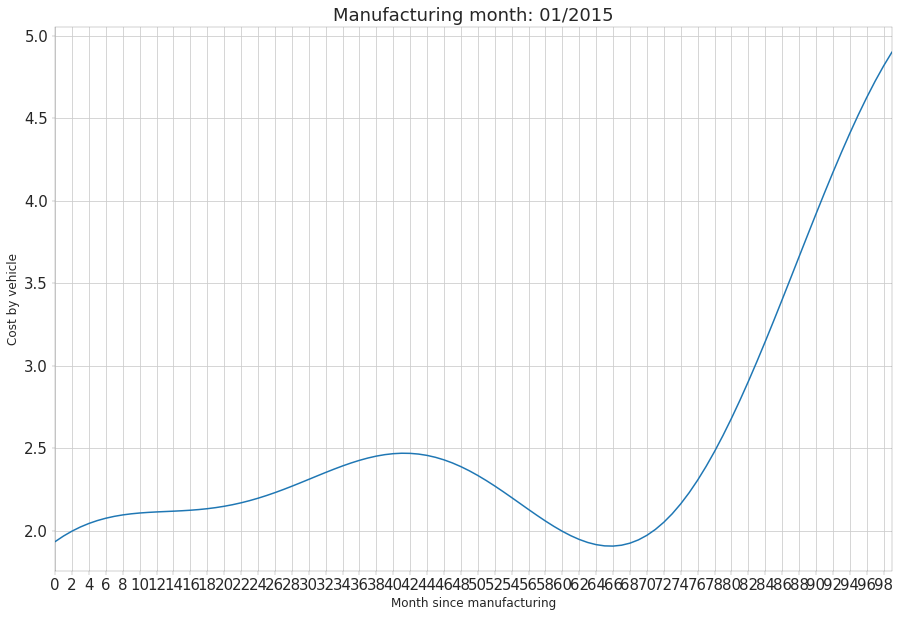

In [110]:
# Plot one month: January 2015
plot_month(df_smooth, date='01/2015')

We do the same smoothing with the cumulative curves.

In [111]:
# Smooth the data (maybe don't)
data = {}
for index, row in df_cum.iterrows():
    data[index] = gaussian_kernel_smoothing(X=np.linspace(0, 24, num=25), y=row, grid=np.linspace(0, 24, num=100))
    
# Reorganize the smoothed data
df_cum_smooth = pd.DataFrame.from_dict({i: data[i][0]
                       for i in data.keys()
                       for j in data[i][0]}, orient='index')

In [112]:
# Compute statistics on the reconstruction error
error = []
for val in data.values():
    error.append(val[1])
print('The R² score on the curves is {:.4f} ± {:.4f}.'.format(np.mean(error), np.std(error)))

The R² score on the curves is 0.9995 ± 0.0005.


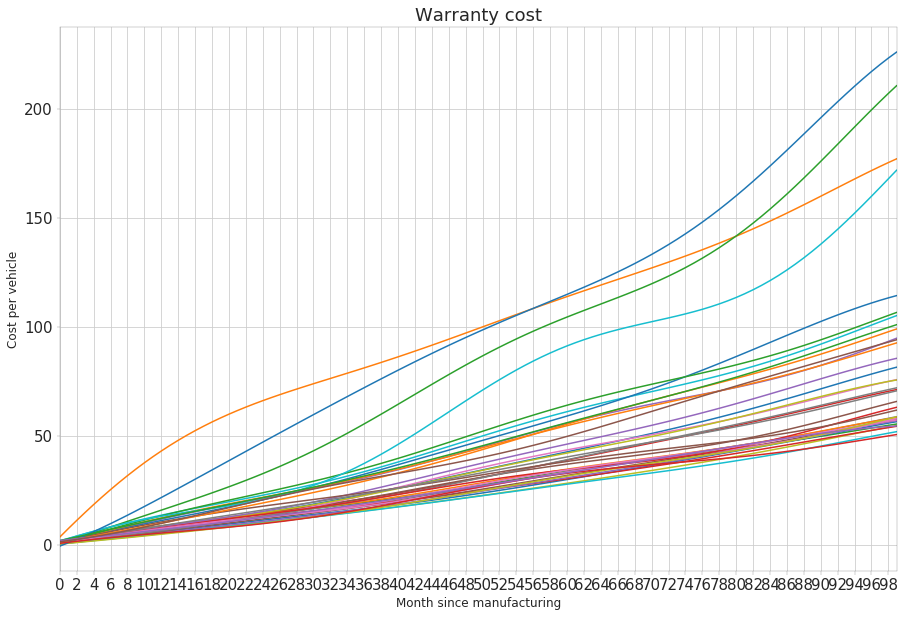

In [113]:
# Plot all the months
plot_months(df_cum_smooth)

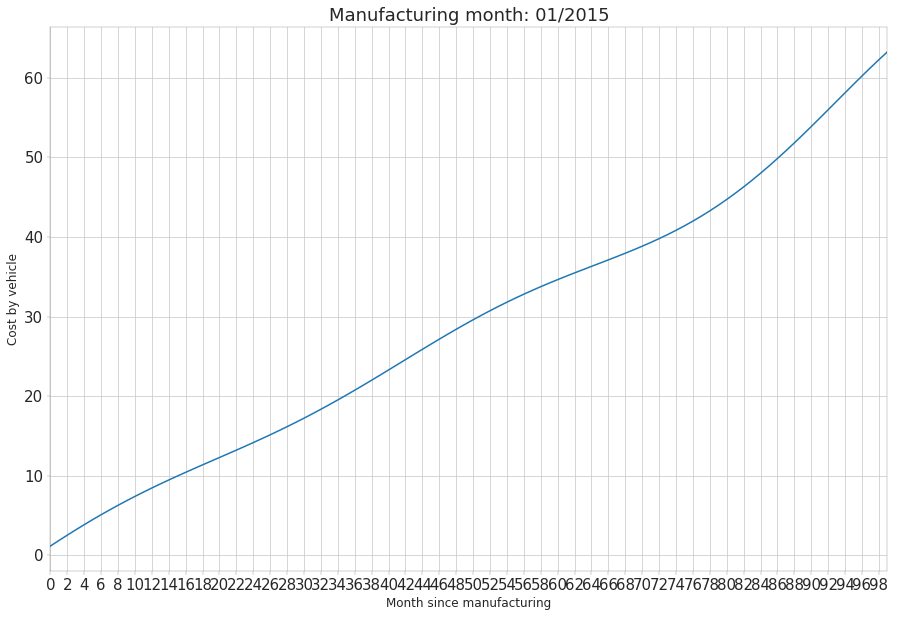

In [114]:
# Plot one month: January 2015
#df_cum_smooth.loc['03/2014']
plot_month(df_cum_smooth, date='01/2015')

## Look at the mean and the covariance matrix the data

In [115]:
# Compute the mean function of the data with and without smoothing.
show(plot_mean(mean(df), norm=False))
show(plot_mean(mean(df_smooth), norm=False))

NameError: name 'plot_mean' is not defined

In [ ]:
# Compute the covariance field of the data with and without smoothing.
show(plot_covariance(covariance(df), norm=False))
show(plot_covariance(covariance(df_smooth), norm=False))

In [ ]:
# Compute the mean function of the cumulative data with and without smoothing.
show(plot_mean(mean(df_cum), norm=False))
show(plot_mean(mean(df_cum_smooth), norm=False))

In [ ]:
# Compute the covariance field of the cumulative data with and without smoothing.
show(plot_covariance(covariance(df_cum), norm=False))
show(plot_covariance(covariance(df_cum_smooth), norm=False))

## Study the data of the cost per vehicle warranty

We use functional Principal Components Analysis to do the study. The idea is to reduce the dimensionality of the curves in order to have a simpler representation of the data. We will first perform the analysis on the non-smoothed data. We seek to explain 95% (99% for the smoothed curves) of the variance with the eigenfunctions.

### On the non-smoothed data

In [ ]:
# Functional PCA on non-smoothed data
fpca = univariate_fpca(df, percent_explained=0.95, whiten=True)

In [ ]:
# Plot the results of the fPCA
show(plot_univariate_fpca(fpca))

In [ ]:
# Plot the pairing scores
sns.set_style('ticks')
g = sns.pairplot(fpca['coef'])
g.fig.set_size_inches(15,10)

In [ ]:
# Plot the evolution of the scores through time.
for i in fpca['coef']:
    plot_coefs(fpca['coef'], i)

### On smoothed data

We will do the same analysis on the smoothed data (the smoothed data are an approximation of the curves).

In [ ]:
# Functional PCA on smoothed data
fpca = univariate_fpca(df_smooth, percent_explained=0.99, whiten=True)

In [ ]:
# Plot the results of the fPCA
show(plot_univariate_fpca(fpca))

In [ ]:
# Plot the pairing scores
sns.set_style('ticks')
g = sns.pairplot(fpca['coef'])
g.fig.set_size_inches(10,10)

In [ ]:
# Plot the evolution of the scores through time.
for i in fpca['coef']:
    plot_coefs(fpca['coef'], i)

## Study the data of the cumulative cost per vehicle warranty

This idea is the same as before, that's to say, functional Principal Components Analysis.

### On the non-smoothed cumulative data

In [ ]:
# Functional PCA on smoothed data
fpca = univariate_fpca(df_cum, percent_explained=0.999, whiten=True)

In [ ]:
# Plot the results of the fPCA
show(plot_univariate_fpca(fpca))

In [ ]:
# Plot the pairing scores
sns.set_style('ticks')
g = sns.pairplot(fpca['coef'])
g.fig.set_size_inches(10,10)

In [ ]:
# Plot the evolution of the scores through time.
for i in fpca['coef']:
    plot_coefs(fpca['coef'], i)